In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

#loading and preprocess the BreakHis dataset
def load_preprocess_dataset(dataset_dir):
    images = []
    labels = []

    cancer_types = os.listdir(dataset_dir)  # getting the list of cancer types (subfolders)

    for label, cancer_type in enumerate(cancer_types):
        type_folder = os.path.join(dataset_dir, cancer_type)
        for img_name in os.listdir(type_folder):
            img_path = os.path.join(type_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path}")
                continue  # skipping this image and proceed with the next one
            img = cv2.resize(img, (260, 260))  # Resizing images to 260x260 pixels
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


dataset_directory = '/content/breast'
images, labels = load_preprocess_dataset(dataset_directory)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels)

# Display dataset shapes after splitting
print(f"Train set - Images: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test set - Images: {X_test.shape}, Labels: {y_test.shape}")

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# defining EfficientNetV2B2 model for multi-class classification
efficientnetv2b2 = tf.keras.applications.EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(260, 260, 3))

model = tf.keras.Sequential([
    efficientnetv2b2,  # using the loaded EfficientNetV2B2 object as the base
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',  # loss function
              metrics=['accuracy'])


# training the model
history = model.fit(X_train, y_train, epochs=6)


#testing the model
predictions = model.predict(X_test)
binary_predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, binary_predictions)
print (accuracy)




Train set - Images: (807, 260, 260, 3), Labels: (807,)
Test set - Images: (202, 260, 260, 3), Labels: (202,)
35839040/35839040 [==============================] - 1s 0us/step
Epoch 1/6
26/26 [==============================] - 406s 14s/step - loss: 1.8553 - accuracy: 0.4015
Epoch 2/6
26/26 [==============================] - 360s 14s/step - loss: 1.0928 - accuracy: 0.8389
Epoch 3/6
26/26 [==============================] - 361s 14s/step - loss: 0.4997 - accuracy: 0.9232
Epoch 4/6
26/26 [==============================] - 365s 14s/step - loss: 0.2149 - accuracy: 0.9628
Epoch 5/6
26/26 [==============================] - 364s 14s/step - loss: 0.1083 - accuracy: 0.9864
Epoch 6/6
7/7 [==============================] - 25s 3s/step
0.9801980198019802


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Functio  (None, 9, 9, 1408)        8769374   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1408)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 11272     
                                                                 
Total params: 8780646 (33.50 MB)
Trainable params: 8698358 (33.18 MB)
Non-trainable params: 82288 (321.44 KB)
_________________________________________________________________


Accuracy 0.9801980198019802
ROC AUC: 0.9996476680654768
Recall: 0.9801980198019802
F1-score: 0.980142552070333


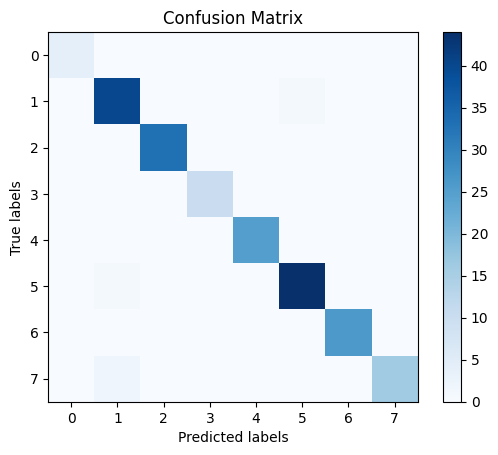

In [ ]:
cm = confusion_matrix(y_test, binary_predictions)
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')
recall = recall_score(y_test, binary_predictions, average='weighted')
f1 = f1_score(y_test, binary_predictions, average='weighted')
accuracy = accuracy_score(y_test, binary_predictions)

print ('Accuracy',accuracy)
print("ROC AUC:", roc_auc)
print("Recall:", recall)
print("F1-score:", f1)

# getting class labels from LabelEncoder
class_labels = le.classes_

# visualization of the confusion matrix with labels
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks(ticks=range(len(class_labels)), labels=class_labels)
plt.yticks(ticks=range(len(class_labels)), labels=class_labels)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

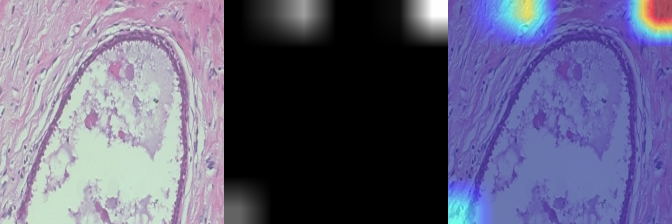

In [ ]:
#Grad cam running
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_path = '/content/breast/MyDrive/Breastv1/Adenosis_All/SOB_B_A-14-22549AB-100-001.png' #paste the image path you want the details for

img = np.array(Image.open(image_path))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)